## Intro 
In this notebook we will apply knowledge gathered from previous analysis to kegg ortologs, this dataset is focused on even lower level biounits than bacteria famillies and pathways, and thus we have much more features, this means we can utilise 1D CNN networks in order to try to reduce number of parameters in the model, We have to remember that CNN try to find structural patterns and we dont necccesarily have ones in our dataset as positioning of columns is random. Nevertheless we decided to test this approach   

### Import libraries and load data

In [1]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
# for tensorboard logs
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, SMOTEN
from keras.layers import Dense, Dropout, Activation, Flatten
import xgboost as xgb
np.random.seed(111)
tf.random.set_seed(111)


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/H2O_based/Data/H2O_KEGG_ortholog_merged.csv')
print(df.shape)
df.head()

(73, 6539)


,timepoint,pond,ID,sample_id,K00001,K00002,K00003,K00004,K00005,K00006,...,K18325,K18471,K18699,K18920,K18921,K18922,K19056,K19234,K19238,K19688
0,0,S08,126,126.0,0.064180,0.000000,0.209235,0.000000,0.201688,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,S08,127,127.0,0.208505,0.000000,0.328480,0.152997,0.450738,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,S08,128,128.0,0.181197,0.198464,0.317529,0.157512,0.221801,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,S14,129,129.0,0.464626,1.000000,0.306387,0.112867,0.266124,0.277778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,S14,130,130.0,0.244841,0.023047,0.131934,0.076248,0.042274,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


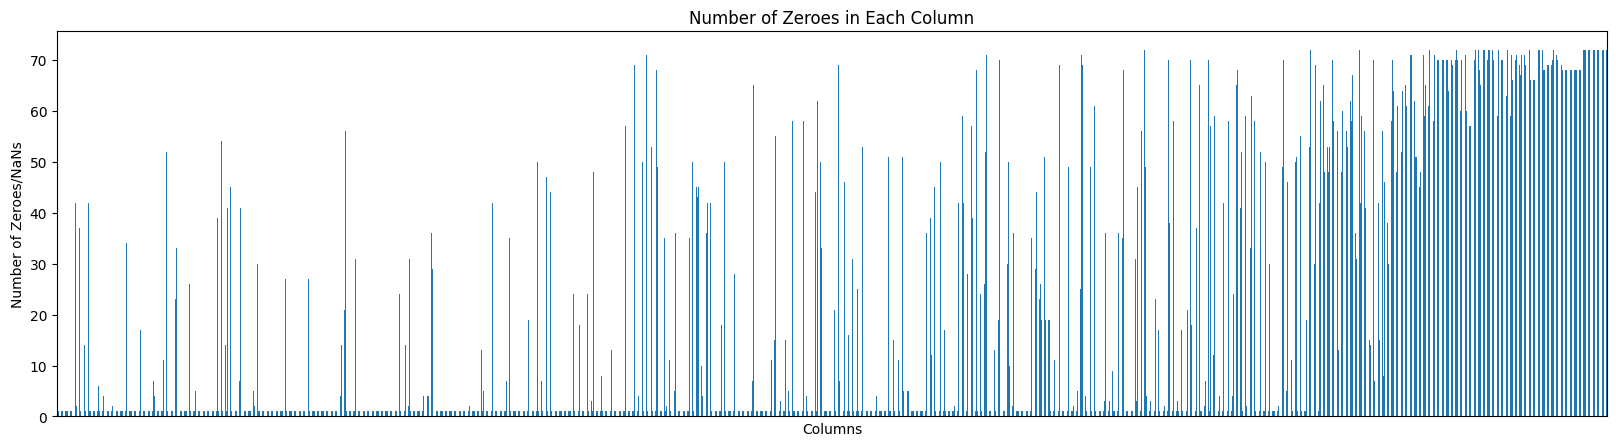

In [3]:
zero_counts = ((df == 0) | (df.isna())).sum()
zero_counts.plot(kind='bar', figsize=(20, 5))
plt.xlabel('Columns')
plt.ylabel('Number of Zeroes/NaNs')
plt.title('Number of Zeroes in Each Column')
plt.xticks([])
plt.show()

We have similar missing observations distribution as for bacteria familly dataset.

In [4]:
df.drop('sample_id', axis=1, inplace=True)

In [5]:
predictors = df.columns[3:]
print("number of predictors: ", len(predictors))

number of predictors:  6535


In [6]:
df[df['pond'] == "S29"]

,timepoint,pond,ID,K00001,K00002,K00003,K00004,K00005,K00006,K00007,...,K18325,K18471,K18699,K18920,K18921,K18922,K19056,K19234,K19238,K19688
11,1,S29,139,0.333501,0.020487,0.18221,0.633057,0.132410,0.160819,0.181166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,2,S29,140,0.260365,0.000000,0.14964,0.231252,0.187907,0.105263,0.242369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df[df['pond'] == "S18"]

,timepoint,pond,ID,K00001,K00002,K00003,K00004,K00005,K00006,K00007,...,K18325,K18471,K18699,K18920,K18921,K18922,K19056,K19234,K19238,K19688
6,1,S18,133,0.14259,0.0,0.084755,0.320542,0.031845,0.0,0.137550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2,S18,134,0.00000,0.0,0.007353,0.034362,0.760507,0.0,0.033993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df.fillna(0, inplace=True)

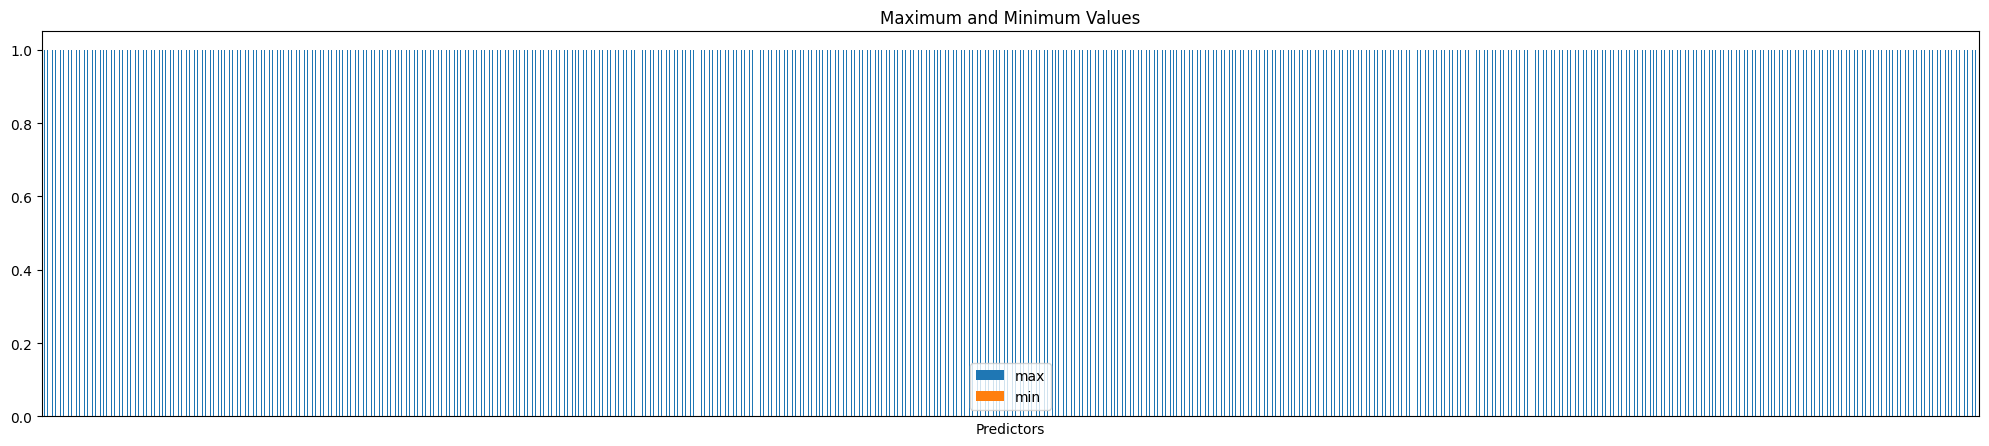

In [9]:
max_values = df[predictors].max()
min_values = df[predictors].min()


max_min_df = pd.DataFrame({'max': max_values, 'min': min_values})
max_min_df.plot(kind='bar', figsize=(25, 5))
plt.title('Maximum and Minimum Values')
plt.xlabel('Predictors')
plt.xticks([])
plt.show()

As the dataset was normalized before using standard scaler there is no needd to do that 



| number | setup | pond numbers | water supplementation | feed supplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [10]:
df['pond_org'] = df['pond']

In [11]:
# Decoding use pond decoder 2 for this

def pond_decoder(x,codes):
   
    x=x.replace('S','')
    num = int(x)
    for key, value_list in codes.items():
        if num in value_list:
            return key
    
    return None   

codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}
codes3 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26, 10,21,28,30,32], 2 : [9,13,17,20,27,11,15,22,25,31]}


df['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))


In [12]:
# defragmenting 
df = df.copy()

In [13]:
df['pondXtime'] = df['class_pond'].astype(str) + "_" + df['timepoint'].astype(str)


In [14]:
le = LabelEncoder()
le3 = LabelEncoder()
df['pondXtime'] = le.fit_transform(df['pondXtime'])
df['pondXtime'].value_counts()


pondXtime
1     5
2     5
3     5
4     5
5     5
6     5
7     5
8     5
9     5
10    5
11    5
12    5
13    5
14    5
0     3
Name: count, dtype: int64

In [15]:
train_val_df, test_df = train_test_split(df, test_size= 0.2, random_state=111, stratify=df['pondXtime'])
print(train_val_df.shape, test_df.shape)

(58, 6541) (15, 6541)


### Definitions

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)


In [17]:
# early stopping callback to save the best model weights for test set
es_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=100,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

### Modeling timepoints
First thing that we are going to try is the only thing that worked properly wchich is modeling timepoints only.

In [18]:
model0 = keras.Sequential()
model0.add(keras.layers.Dense(1024,input_shape=(len(predictors),),activation='relu'))
model0.add(keras.layers.Dense(254, activation ='relu'))
model0.add(keras.layers.Dropout(rate=0.25))
model0.add(keras.layers.Dense(128, activation ='relu'))

model0.add(keras.layers.Dense(64, activation ='relu'))
model0.add(keras.layers.Dense(16, activation ='relu'))
model0.add(keras.layers.Dropout(rate=0.25))
model0.add(keras.layers.Dense(16, activation ='relu'))

model0.add(keras.layers.Dense(3, activation ='softmax'))

print(model0.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model0.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │     6,692,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,995,473 (26.69 MB)

 Trainable params: 6,995,473 (26.69 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 3
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8667 - loss: 0.3736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
predicted classes:       [2 2 2 1 1 1 1 1 2 1 1 1 0 1 2]
true validation classes: [2 2 2 1 1 1 2 1 2 1 0 1 0 1 2]
mean confidence score: 1608202641594.739, sd confidence score: 5747526999999.426
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 2.3846e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [0 1 0 0 0 2 2 0 0 1 0 1 0 0 1]
true validation classes: [0 1 0 0 0 2 2 0 0 1 0 1 0 0 1]
mean confidence score: 1.1364490559934322e+16, sd confidence score: 4.2520587428727256e+16
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0430
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted classes:       [1 1 1 2 1 2 1 2 1 2 1 0 2 1 2]
true validation classes: [1 1 1 2 1 2 1 2 1 2 1 0 2 1 2]
mean confidence score: 3.7628947005540653e+21, sd confidence sco

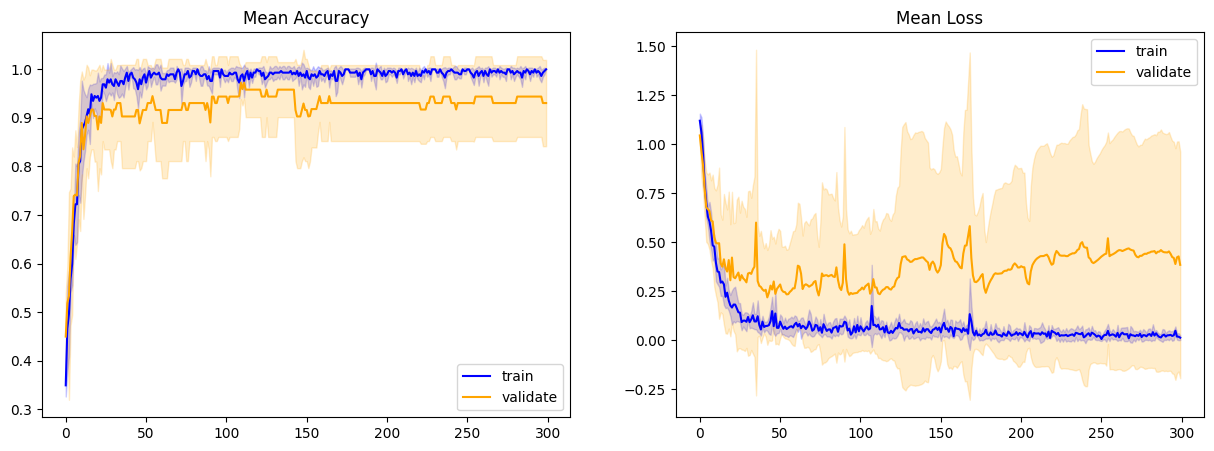

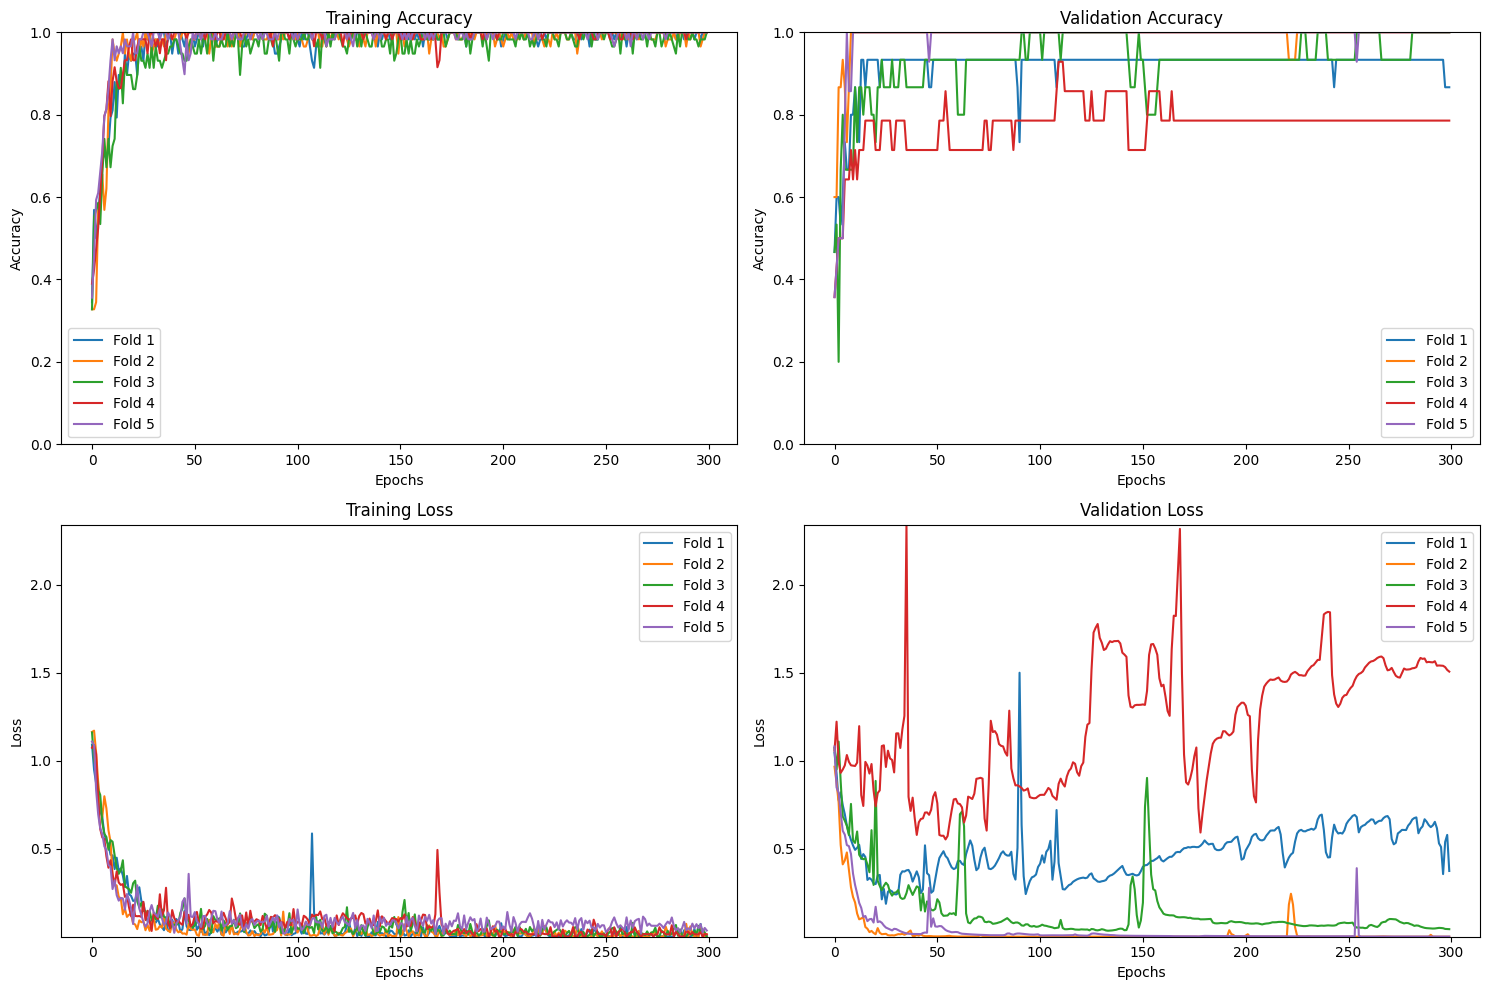

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [2 0 2 2 1 0 2 0 0 0 1 2 2 2]
true validation classes: [2 0 2 2 1 0 2 0 0 0 1 2 2 2]


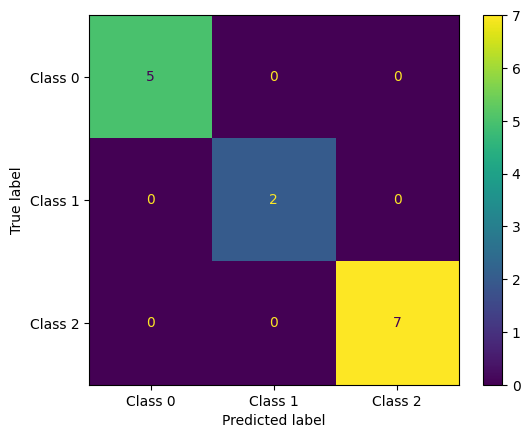

In [19]:
crossvalidate(df, model0, predictors, 'timepoint', kf)

As we can see for KO dataset it worked perfectly as well, the model is much bigger and thus the loss functions are fluctuating much more but we have very nice accuracy.

In [20]:
model0c = keras.Sequential()

model0c.add(keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu',input_shape = (len(predictors),1)))
model0c.add(keras.layers.Conv1D(filters=2, kernel_size=3, activation='relu'))


model0c.add(Flatten())

model0c.add(keras.layers.Dense(1024, activation ='relu'))
model0c.add(keras.layers.Dense(254, activation ='relu'))
model0c.add(keras.layers.Dropout(rate=0.25))

model0c.add(keras.layers.Dense(128, activation ='relu'))

model0c.add(keras.layers.Dense(64, activation ='relu'))
model0c.add(keras.layers.Dense(16, activation ='relu'))
model0c.add(keras.layers.Dropout(rate=0.25))
model0c.add(keras.layers.Dense(16, activation ='relu'))

model0c.add(keras.layers.Dense(3, activation ='softmax'))

print(model0c.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model0c.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6531, 3)        │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6529, 2)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13058)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │    13,372,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,675,063 (52.17 MB)

 Trainable params: 13,675,063 (52.17 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 3
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9333 - loss: 0.4180
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
predicted classes:       [2 2 2 1 1 1 0 1 2 1 0 1 0 1 2]
true validation classes: [2 2 2 1 1 1 2 1 2 1 0 1 0 1 2]
mean confidence score: 226369316.2036, sd confidence score: 376327553.7819
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 1.5793e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
predicted classes:       [0 1 0 0 0 2 2 0 0 1 0 1 0 0 1]
true validation classes: [0 1 0 0 0 2 2 0 0 1 0 1 0 0 1]
mean confidence score: 108382396.8197, sd confidence score: 228831295.3092
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9333 - loss: 1.3838
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted classes:       [1 1 1 2 1 2 1 2 0 2 1 0 2 1 2]
true validation classes: [1 1 1 2 1 2 1 2 1 2 1 0 2 1 2]
mean confidence score: 26118039.0733, sd confidence score: 71097558.4351
training for

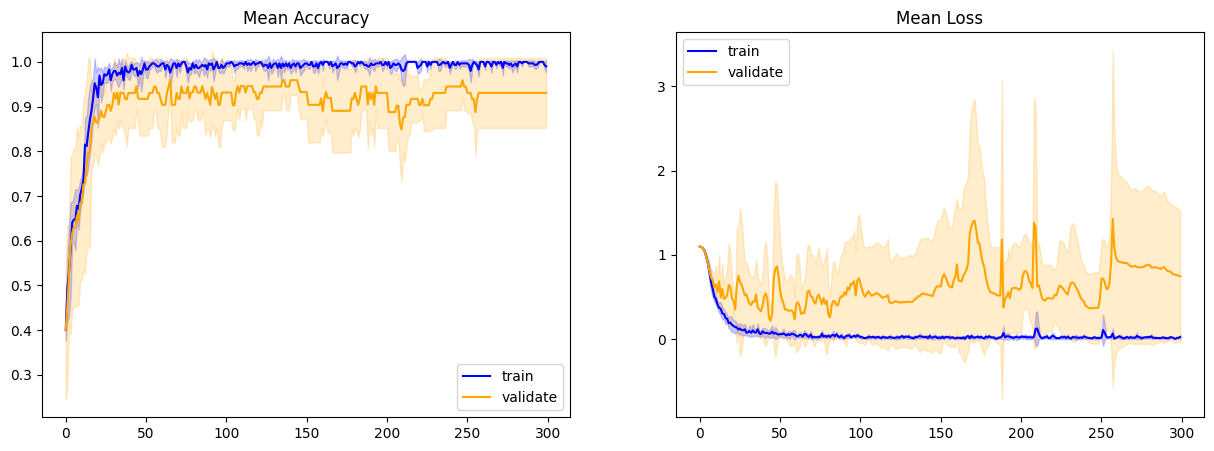

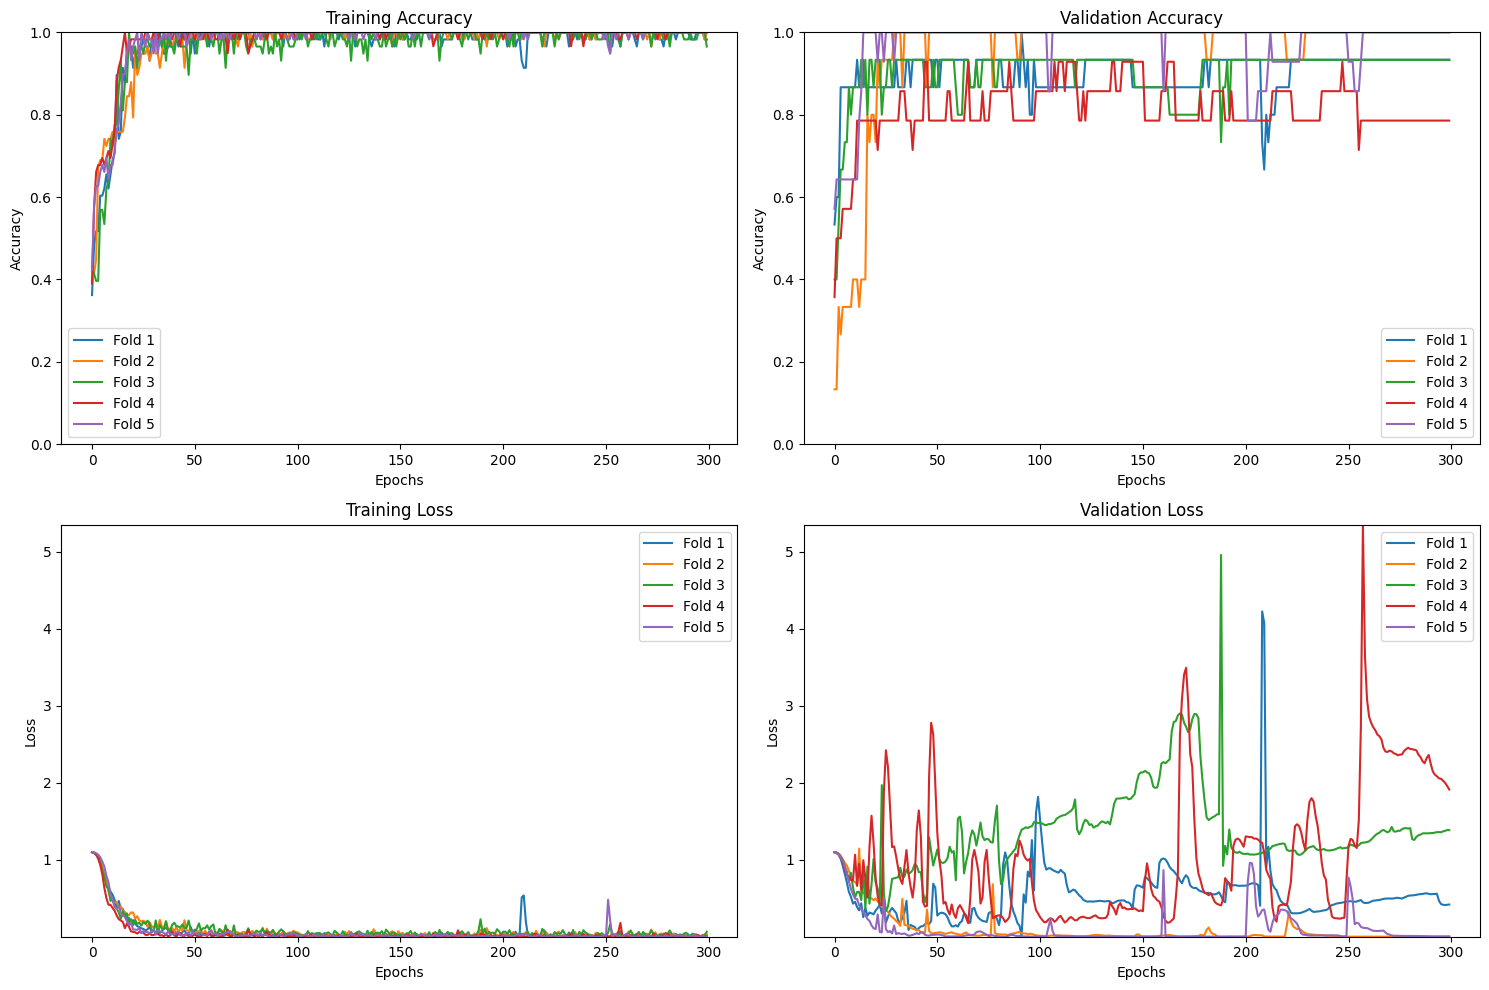

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
predicted classes:       [2 0 2 2 1 0 2 0 0 0 1 2 2 2]
true validation classes: [2 0 2 2 1 0 2 0 0 0 1 2 2 2]


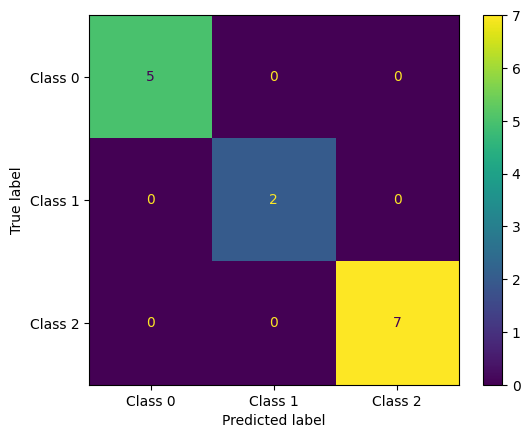

In [21]:
crossvalidate(df, model0c, predictors, 'timepoint', kf)

Convolutional approach proved to yield only slightl worse results than the non convolutional having very good accuracy for all the folds. We can also note that learning loss curve for training dataset is smoother this is probably because of early reduction of data performed by convolution layers.

### Convolution only ponds

In [22]:
model2 = keras.Sequential()

model2.add(keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu',input_shape = (len(predictors),1)))
model2.add(keras.layers.Conv1D(filters=2, kernel_size=3, activation='relu'))


model2.add(Flatten())

model2.add(keras.layers.Dense(1024, activation ='relu'))
model2.add(keras.layers.Dense(254, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))

model2.add(keras.layers.Dense(128, activation ='relu'))

model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dense(16, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

print(model2.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 6531, 3)        │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6529, 2)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13058)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │    13,372,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,675,097 (52.17 MB)

 Trainable params: 13,675,097 (52.17 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.5333 - loss: 3.6550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
predicted classes:       [0 1 1 0 0 2 3 2 2 0 4 3 4 2 4]
true validation classes: [0 1 1 1 1 1 2 2 2 3 3 3 4 4 4]
mean confidence score: 760341.2585, sd confidence score: 2813282.1106
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0667 - loss: 8.3986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
predicted classes:       [1 2 2 4 2 0 3 2 2 1 2 2 2 2 2]
true validation classes: [0 0 0 1 1 2 3 3 3 3 3 4 4 4 4]
mean confidence score: 345918.1106, sd confidence score: 1284441.9045
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1333 - loss: 6.1191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
predicted classes:       [0 1 3 2 4 4 0 0 1 3 4 2 1 1 0]
true validation classes: [0 0 1 1 2 2 2 2 3 3 3 4 4 4 4]
mean confidence score: 1006.9277, sd confidence score: 2687.6162
training for 4 subset
1/1 ━━━━━━━━

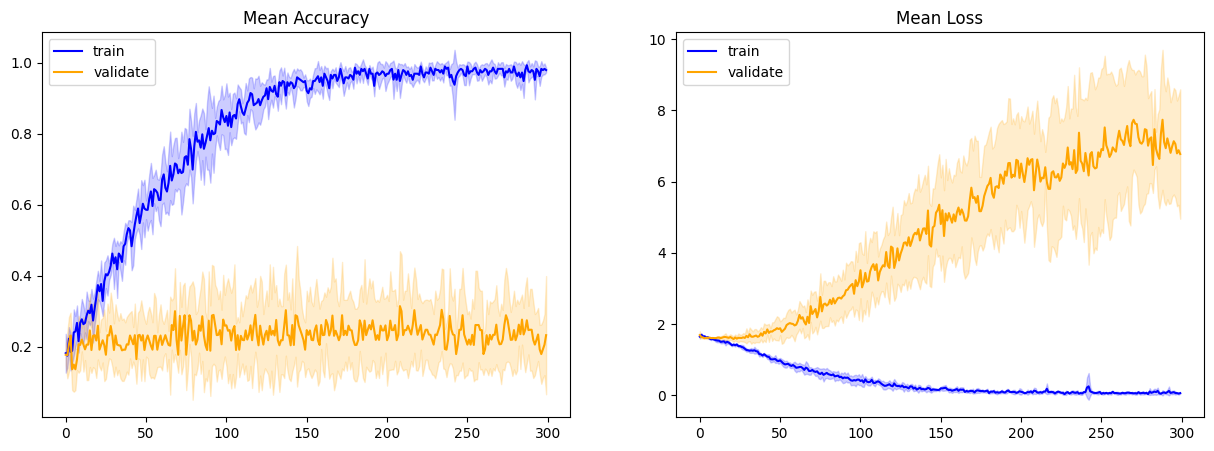

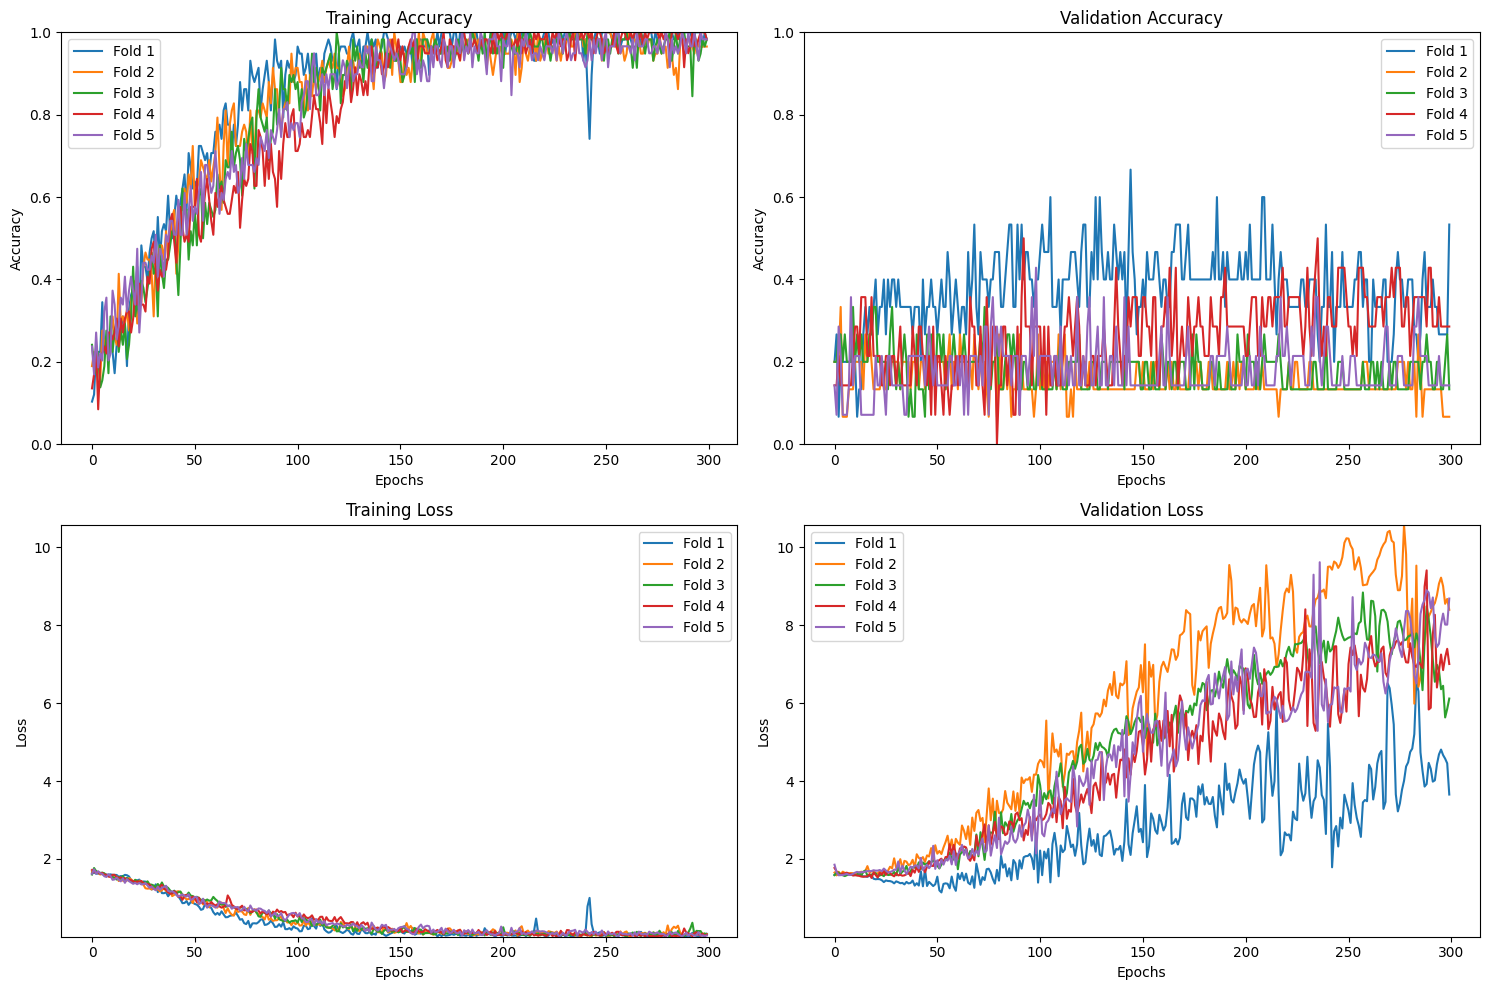

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
predicted classes:       [3 3 2 1 2 0 3 4 4 4 2 3 1 2]
true validation classes: [0 0 0 0 1 1 1 2 2 2 2 3 3 4]


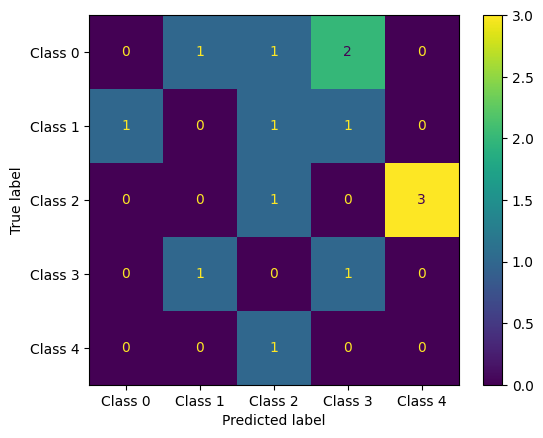

In [23]:
crossvalidate(df, model2, predictors, 'class_pond', kf, True)

As we've seen for bacteria datasets modeling differences between ponds didnt result in any good classification.

### Modeling ponds in 1 timepoint

In [72]:
df_1_tp = df[df['timepoint'] == 0]

In [ ]:
reset_weights(model2)
model2 = keras.Sequential()

model2.add(keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu',input_shape = (len(predictors),1)))
model2.add(keras.layers.Conv1D(filters=2, kernel_size=3, activation='relu'))


model2.add(Flatten())

model2.add(keras.layers.Dense(1024, activation ='relu'))
model2.add(keras.layers.Dense(254, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))

model2.add(keras.layers.Dense(128, activation ='relu'))

model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dense(16, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

print(model2.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 256)            │     1,673,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,690,789 (6.45 MB)

 Trainable params: 1,690,789 (6.45 MB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4000 - loss: 1.6998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
predicted classes:       [1 1 4 0 0]
true validation classes: [1 1 2 3 3]
mean confidence score: 1.0622, sd confidence score: 0.4091
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4000 - loss: 1.7376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [1 4 1 3 2]
true validation classes: [0 1 1 3 3]
mean confidence score: 1.2836, sd confidence score: 1.1861
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4000 - loss: 1.5450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [3 2 3 2 2]
true validation classes: [0 2 3 4 4]
mean confidence score: 3.2613, sd confidence score: 1.1984
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 2.3859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
predicted classes:       [3 4 1 4]
true validat

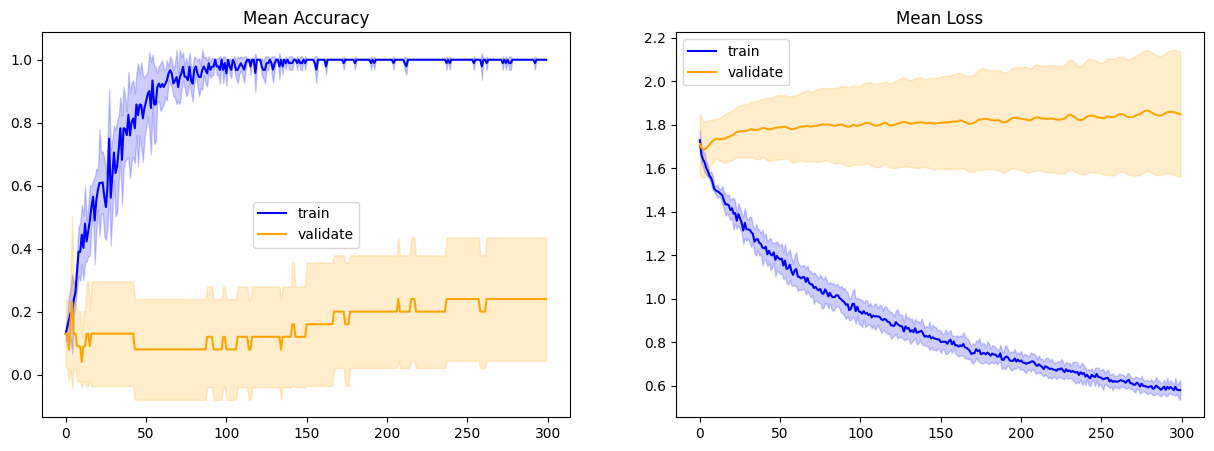

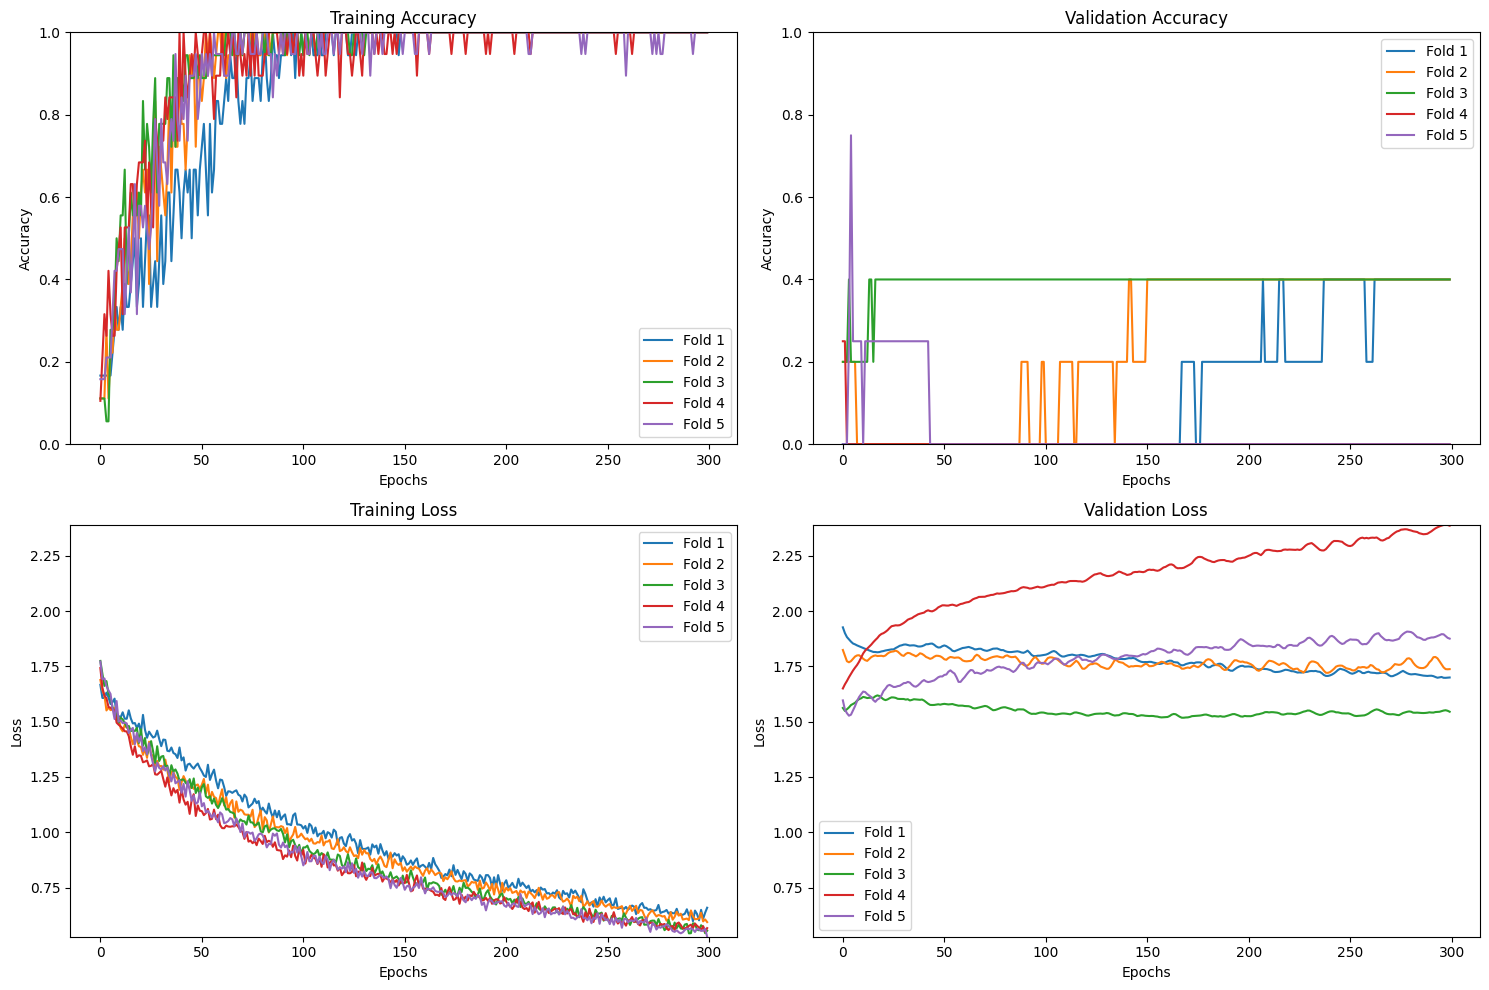

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [4 1 0 1]
true validation classes: [2 4 4 4]


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (5).

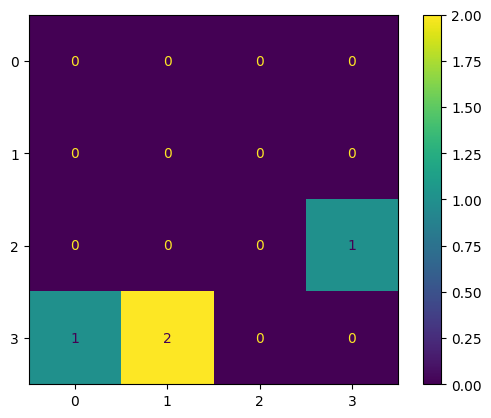

In [74]:
crossvalidate(df_1_tp, model2, predictors, 'class_pond', kf)

XXXXX

### Modeling ponds in second timepoint

In [75]:
df_2_tp = df[df['timepoint'] == 1]

In [ ]:
reset_weights(model2)
model2 = keras.Sequential()

model2.add(keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu',input_shape = (len(predictors),1)))
model2.add(keras.layers.Conv1D(filters=2, kernel_size=3, activation='relu'))


model2.add(Flatten())

model2.add(keras.layers.Dense(1024, activation ='relu'))
model2.add(keras.layers.Dense(254, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))

model2.add(keras.layers.Dense(128, activation ='relu'))

model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dense(16, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

print(model2.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 256)            │     1,673,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,690,789 (6.45 MB)

 Trainable params: 1,690,789 (6.45 MB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2000 - loss: 2.1072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
predicted classes:       [4 3 2 4 1]
true validation classes: [0 0 2 2 3]
mean confidence score: 1.8547, sd confidence score: 1.2361
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 2.1974
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [2 4 4 0 4]
true validation classes: [1 1 2 3 3]
mean confidence score: 2.2532, sd confidence score: 0.9298
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2000 - loss: 1.6331
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [2 4 4 2 4]
true validation classes: [0 0 2 3 4]
mean confidence score: 2.9379, sd confidence score: 2.4668
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 2.3701
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [2 3 0 2 2]
true v

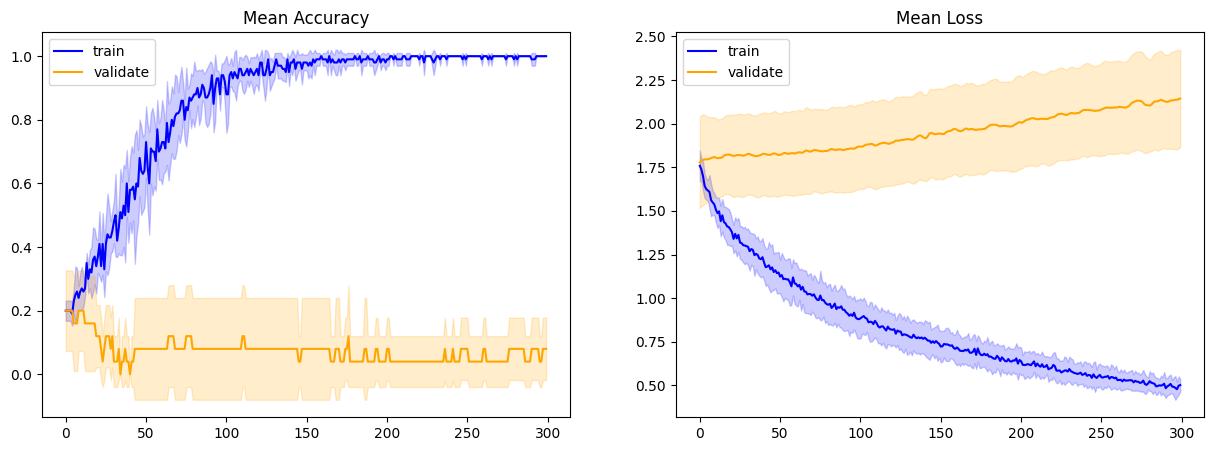

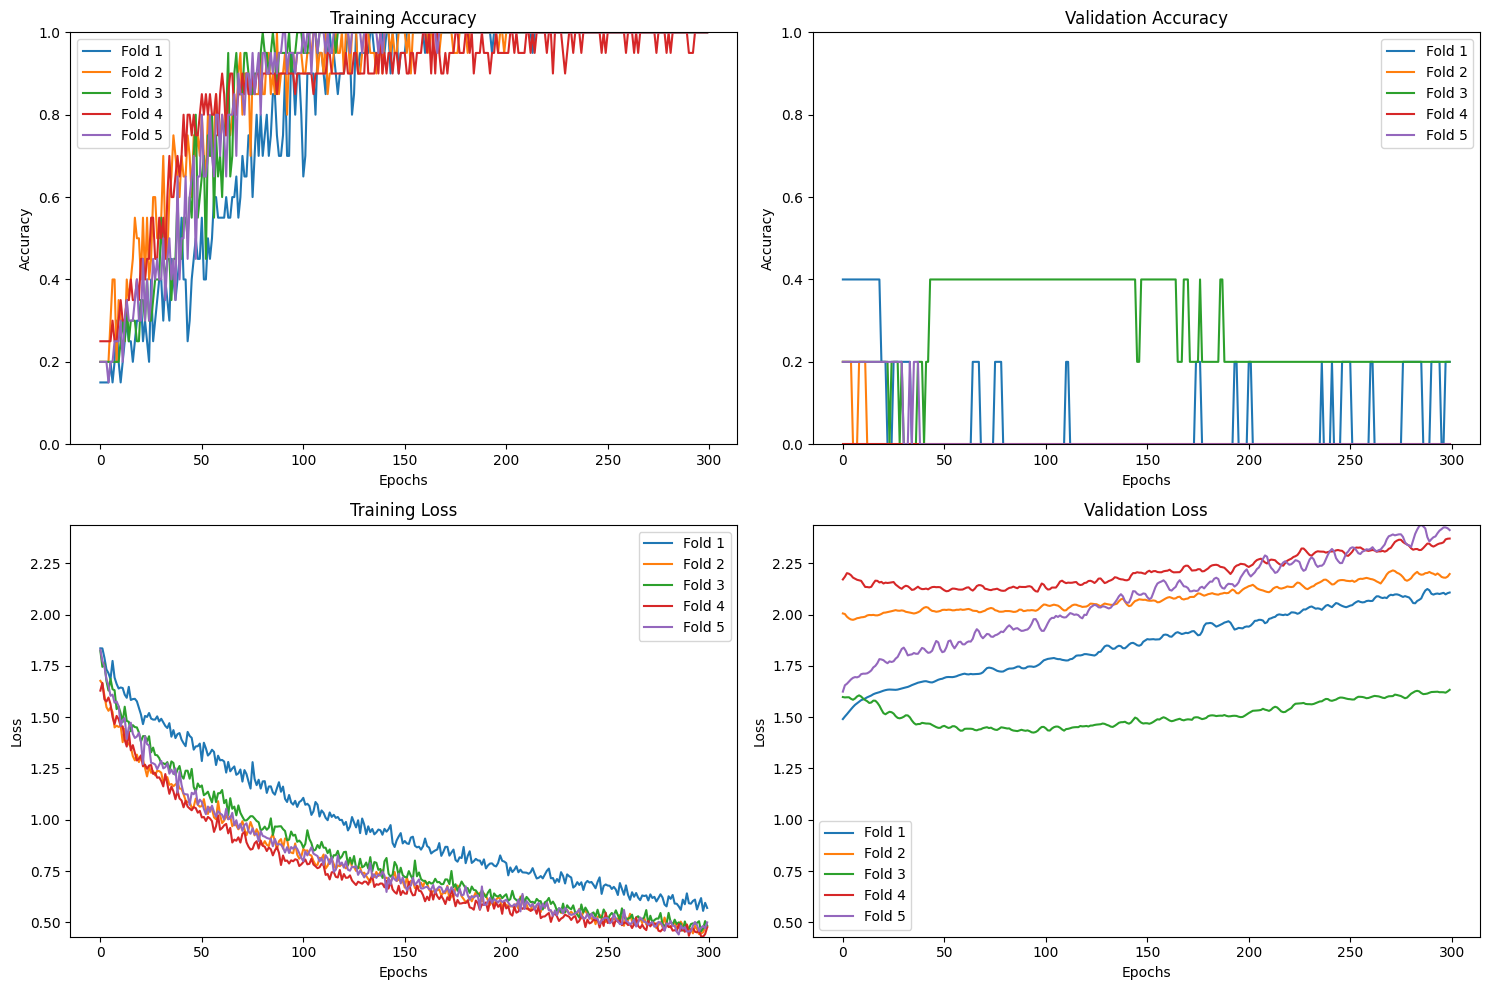

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [0 2 1 1 2]
true validation classes: [2 3 4 4 4]


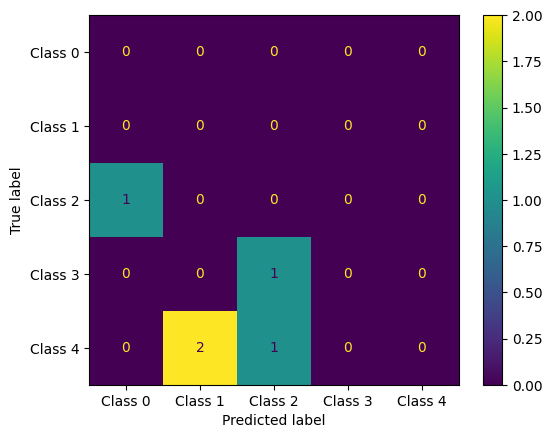

In [78]:
crossvalidate(df_2_tp, model2, predictors, 'class_pond', kf)

### Modeling ponds in third timepoint

In [80]:
df_3_tp = df[df['timepoint'] == 2]

In [ ]:
reset_weights(model2)
model2 = keras.Sequential()

model2.add(keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu',input_shape = (len(predictors),1)))
model2.add(keras.layers.Conv1D(filters=2, kernel_size=3, activation='relu'))


model2.add(Flatten())

model2.add(keras.layers.Dense(1024, activation ='relu'))
model2.add(keras.layers.Dense(254, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))

model2.add(keras.layers.Dense(128, activation ='relu'))

model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dense(16, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

print(model2.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_47 (Dense)                │ (None, 256)            │     1,673,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,690,789 (6.45 MB)

 Trainable params: 1,690,789 (6.45 MB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2000 - loss: 1.8475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predicted classes:       [3 1 0 3 3]
true validation classes: [0 0 2 2 3]
mean confidence score: 2.3364, sd confidence score: 2.17
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 2.3160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [3 0 4 0 4]
true validation classes: [1 1 2 3 3]
mean confidence score: 3.0554, sd confidence score: 1.5715
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4000 - loss: 1.3645
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [0 4 4 3 2]
true validation classes: [0 0 2 3 4]
mean confidence score: 3.1206, sd confidence score: 1.3023
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 2.4731
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [1 0 4 2 3]
true vali

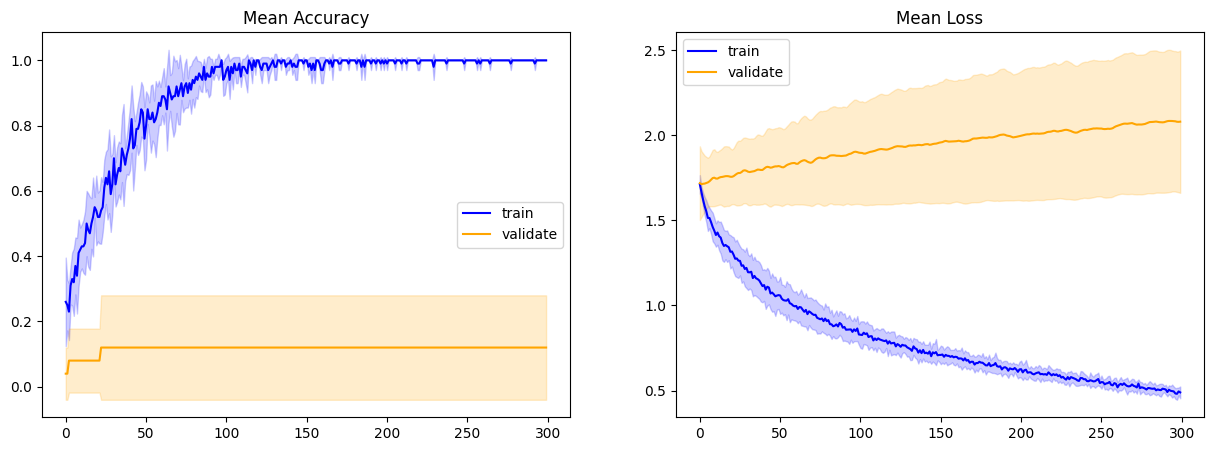

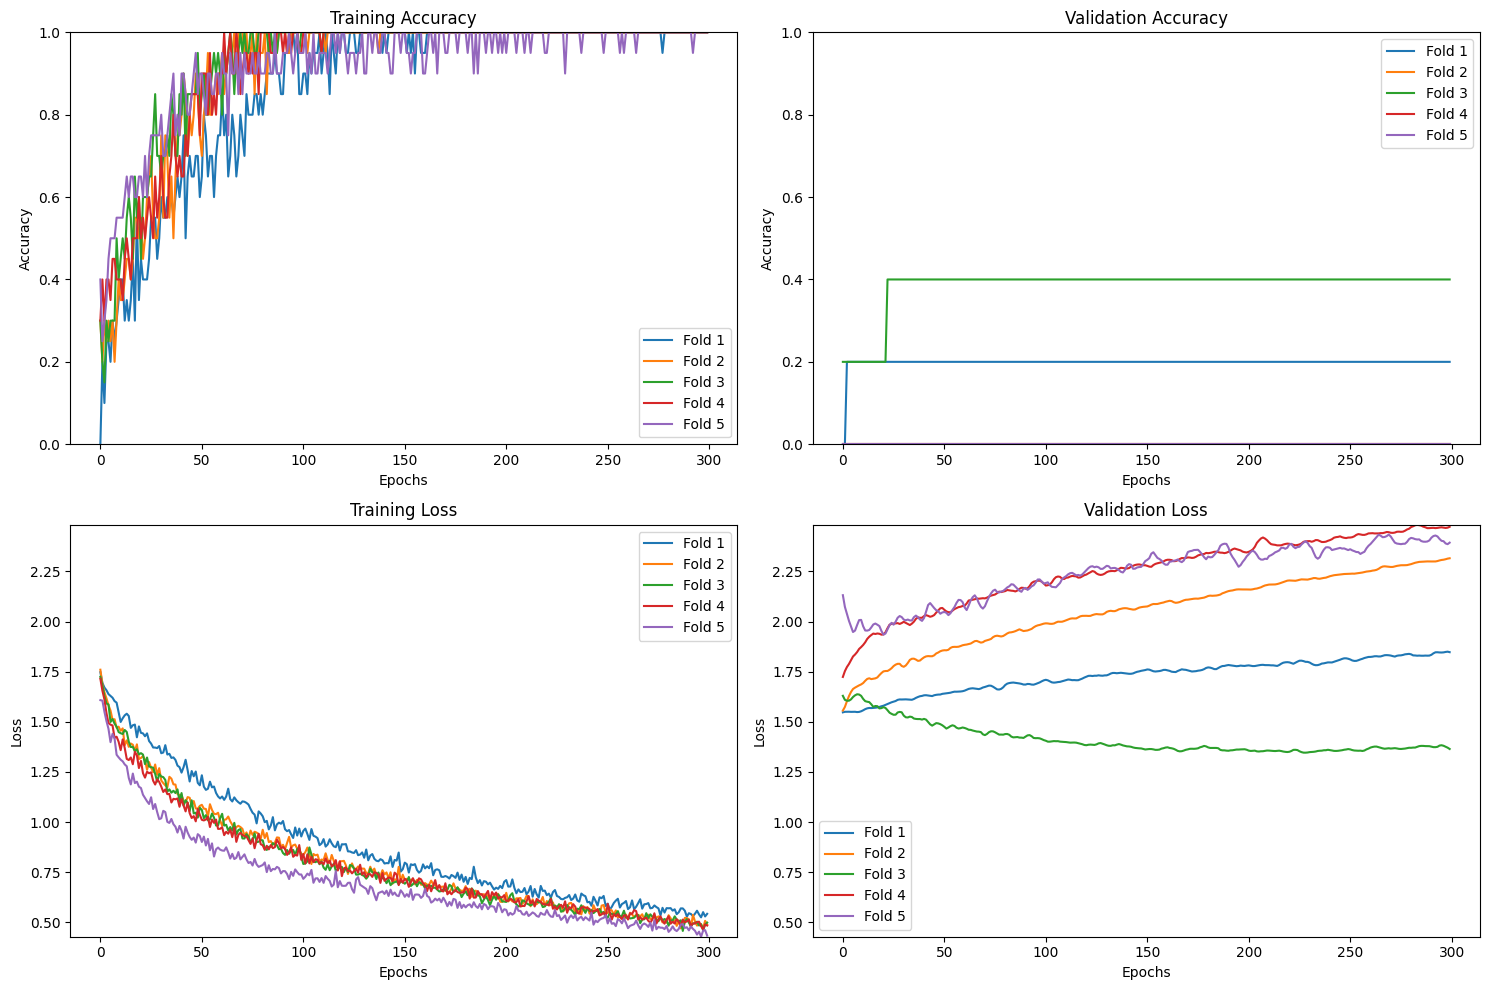

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
predicted classes:       [1 0 1 0 1]
true validation classes: [2 3 4 4 4]


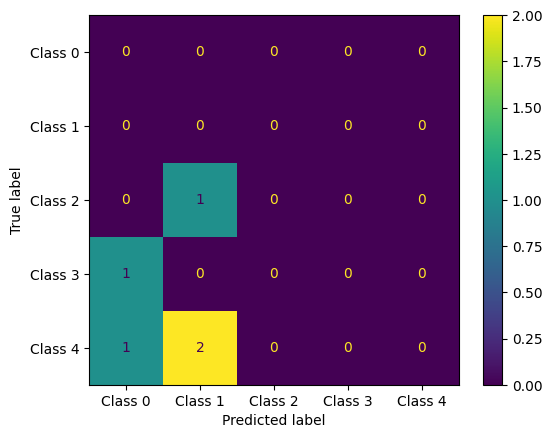

In [82]:
crossvalidate(df_3_tp, model2, predictors, 'class_pond', kf)

For both of the timepoints we were not able to classify with any satisfactionary results for any fold, this is the same case as for bacteria dataset.

### Modeling ponds and timepoints at the same time

In [ ]:
reset_weights(model2)

crossvalidate(df, model2, predictors, 'pondXtime', kf)

#### With Convolution

In [ ]:
reset_weights(model2)
model2 = keras.Sequential()

model2.add(keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu',input_shape = (len(predictors),1)))
model2.add(keras.layers.Conv1D(filters=2, kernel_size=3, activation='relu'))


model2.add(Flatten())

model2.add(keras.layers.Dense(1024, activation ='relu'))
model2.add(keras.layers.Dense(254, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))

model2.add(keras.layers.Dense(128, activation ='relu'))

model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dense(16, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

print(model2.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [ ]:
crossvalidate(df, model2, predictors, 'pondXtime', kf, True)

## XGBoost analysis

For comparison we will replicate our analysis use XGBoost which is based on Gradient Boosting and utilising Decision trees, we could use Random forests but this prooved to be a better approach for smaller dataset and we dont require faster and better computing performance that are offered by random forests.

In [18]:
train_val_df.shape, test_df.shape

((58, 6541), (15, 6541))

In [19]:
X_train = train_val_df[predictors].values
X_test = test_df[predictors].values


### Modeling timepoints only

In [28]:
dtrain = xgb.DMatrix(X_train, label=train_val_df['timepoint'])
dtest = xgb.DMatrix(X_test, label=test_df['timepoint'])
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 5,
    'eta': 0.1,
    'seed': 111

}
bst2 = xgb.train(params, dtrain, 100, num_boost_round=100)

#xgb.plot_importance(bst2)
xgb_pred = bst2.predict(dtest)
xgb_acc = accuracy_score(test_df['timepoint'], xgb_pred)


[2 0 0 0 0 2 1 0 1 2 2 2 1 1 1]
[1. 0. 0. 0. 1. 1. 1. 0. 1. 2. 2. 2. 1. 1. 1.]
0.8


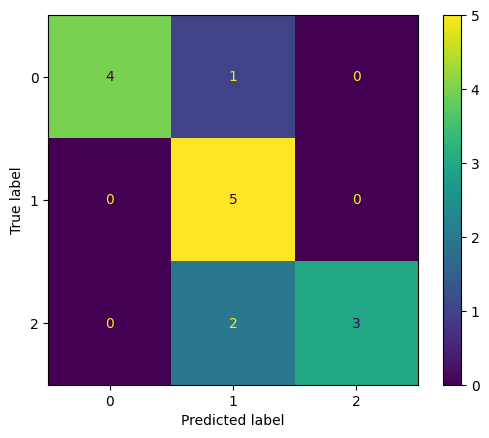

In [29]:
print(test_df['timepoint'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(test_df['timepoint'].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()

When comparing our Nerual network approach to some more robust machine learning approach as XGBoost we can see that for first analysis whchich is modeling only timepoints we have worse accuracy >>>>possible cause for that can be that it is high dimentionality dataset with many features and neural network approaches tend to have better results on those<<<

### Classifying only ponds for both timepoints

In [32]:
dtrain = xgb.DMatrix(X_train, label=train_val_df['class_pond'].values)  
dtest = xgb.DMatrix(X_test, label=test_df['class_pond'].values)
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}

bst2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst2.predict(dtest)
xgb_acc = accuracy_score(test_df['class_pond'].values, xgb_pred)

['S11' 'S26' 'S21' 'S11' 'S09' 'S20' 'S14' 'S08' 'S27' 'S21' 'S23' 'S18'
 'S15' 'S12' 'S30']
[1. 3. 4. 4. 4. 4. 1. 1. 4. 4. 3. 1. 2. 2. 4.]
0.06666666666666667


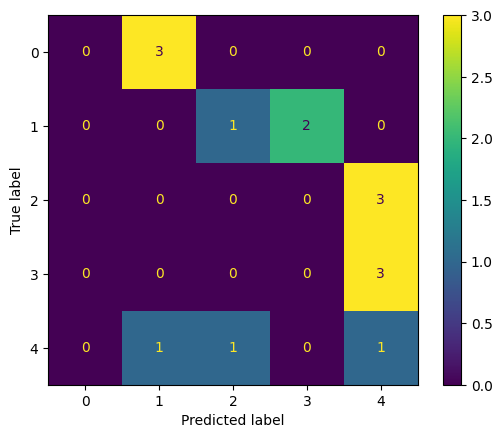

In [33]:
print(test_df['pond'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(test_df['class_pond'].values, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

For our ponds all timepoints at the same time we can see that the results are very bad. 

#### Modeling only first timepoint

In [34]:
df_first_tp = df[df['timepoint'] == 0]
print(df_first_tp.shape)
df1tp_train, df1tp_test = train_test_split(df_first_tp, test_size=10, random_state=111, stratify=df_first_tp['class_pond'])
X_2_train = df1tp_train[predictors].values
X_2_test = df1tp_test[predictors].values

(23, 6541)


In [35]:
dtrain = xgb.DMatrix(X_2_train, label=df1tp_train['class_pond'].values)
dtest = xgb.DMatrix(X_2_test, label=df1tp_test['class_pond'].values)
bst3_1 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst3_1.predict(dtest)
xgb_acc = accuracy_score(df1tp_test['class_pond'].values, xgb_pred)

[4 0 4 3 1 0 2 1 2 3]
[1. 3. 2. 0. 0. 2. 4. 1. 1. 0.]
0.1


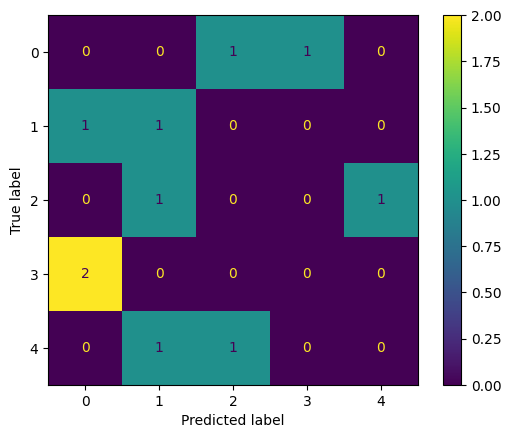

In [36]:
print(df1tp_test['class_pond'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(df1tp_test['class_pond'].values, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

### Modeling only second timepoint

In [38]:
df_second_tp = df[df['timepoint'] == 1]
df_second_tp.shape

df_2tp_train, df_2tp_test = train_test_split(df_second_tp, test_size=5, random_state=111, stratify=df_second_tp['class_pond'])
print(df_2tp_train.shape, df_2tp_test.shape)
X_2_train = df_2tp_train[predictors].values
y_2_train = df_2tp_train['class_pond'].values
X_2_test = df_2tp_test[predictors].values
y_2_test = df_2tp_test['class_pond'].values



(20, 6541) (5, 6541)


In [39]:
dtrain = xgb.DMatrix(X_2_train, label=y_2_train)  
dtest = xgb.DMatrix(X_2_test, label=y_2_test)
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}

bst3 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst3.predict(dtest)
xgb_acc = accuracy_score(y_2_test, xgb_pred)

[2 4 1 0 3]
[4. 4. 0. 3. 4.]
0.2


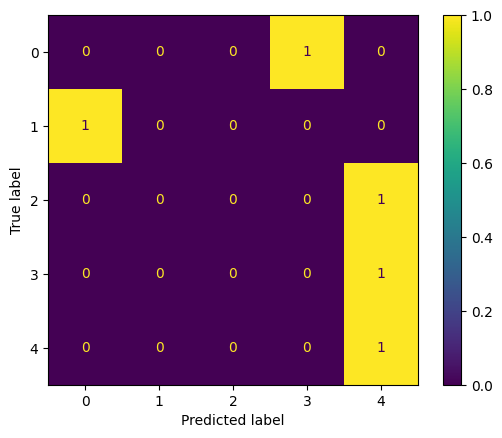

In [40]:
print(y_2_test)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(y_2_test, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

Again for modeling for single timepoints we cant really perform any good classification. This is last anlysis as for H2O as well as for Sediment we could not performy any good classification between experimetnal setups for any dataset and for any approach, possible cause for that is that there are no significant enough differences between experimetnal setups and the only differences are 

### Conclusions from XGBoost
The results from the XGBoost model are slightly better especially for modeeling ponds in 1 timepoint to those obtained with neural networks, For The modelinga imed at classyifing ponds the results were bad only slightly better than for NN's this somewhat prooves that there might be not significant enough differences between ponds for the algorythm to detect.